In [8]:
import numpy as np
from keras.datasets import fashion_mnist
import math
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import wandb
import scikitplot as skplt

In [9]:
!wandb login

wandb: Currently logged in as: cs23z036. Use `wandb login --relogin` to force relogin


4422102/4422102 [==============================] - 0s 0us/step


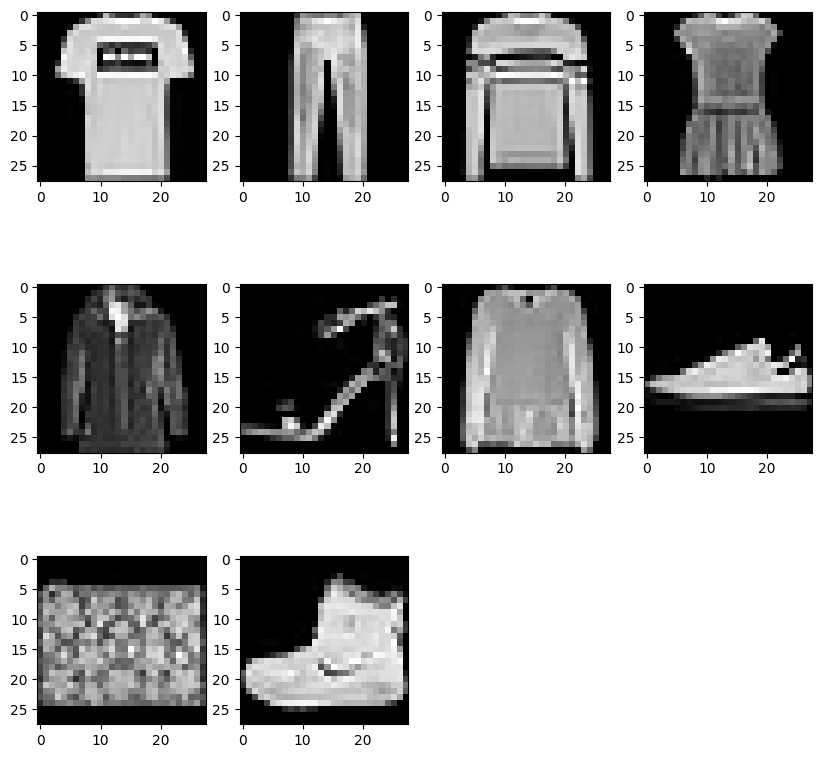

In [10]:
# getting one sample image from each class and visualizing
(x_train,y_train), (x_test,y_test)= fashion_mnist.load_data()
classes = np.unique(y_train)
index_mat = [0]*10
for i in classes:
  index_mat[i] = y_train.tolist().index(i)

plt.figure(figsize=(10,10))

for j, i in enumerate(index_mat):
  plt.subplot(3,4,j+1)
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

plt.show()

In [12]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
wandb.init(project='Assignment1_ReLoaded_15thJuly')

wandb.log({'sample':[wandb.Image(x_train[i],caption=class_names[y_train[i]]) for i in index_mat]})


In [ ]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [ ]:
x_train=x_train.reshape(60000,28*28)/255
x_test=x_test.reshape(10000,28*28)/255
y_test=y_test
temp=np.zeros((60000,10))
temp[np.arange(60000),y_train]=1
y_train=temp

In [ ]:
config_defaults = {
        'epochs': 5,
        'batch_size':32,
        'hidden_layers':3,
        'eta': 0.001,
        'size':32,
        'activation': 'sigmoid',      #available: sigmoid,tanh,relu
        'optimizer': 'nesterov',       # available : sgd,momnetum,rmsprop,nesterov,adam,adagrad
        'wt_decay':0.05,
        'wt_init':'xavier'
        }
config=config_defaults

In [ ]:
sweep_config = {
  'name': 'Assignment1_ReLoaded',
  'method': 'grid',
  'parameters': {
        'epochs': {
            'values': [5]
        },
        'batch_size':{
            'values':[32]
        },
        'hidden_layers':{
            'values':[2,3]
        },
        'eta': {
            'values': [0.005]
        },
        'size':{
            'values':[32,64]
        },
        'optimizer': {
            'values': ['nesterov','rmsprop']
        },
        'activation': {
            'values': ['sigmoid','tanh']
        },
        'wt_decay': {
            'values': [0.005,0.05]
        },
        'wt_init':{
            'values':['xavier','random']
        }
    }
}


In [ ]:
#Activation functions and their derivatives

def sigmoid(x):
  return 1/(1+np.exp(-x))

def tanh(x):
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def softmax(x):
  exps=np.exp(x)
  return exps/np.sum(exps)

def grad_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

def grad_tanh(x):
  return 1-(tanh(x)**2)



In [ ]:
best_acc=0
def Train():
  X=x_train[:50000]
  Y=y_train[:50000]

  x_val=x_train[50000:]
  y_val=y_train[50000:]

  wandb.init(config=config_defaults)
  config = wandb.config


  eta = config['eta']
  epochs = config['epochs']
  batch_size=config['batch_size']
  activation=config['activation']
  optimization=config['optimizer']
  num_hidden_layers = config['hidden_layers']
  size=config['size']
  wt_decay=config['wt_decay']
  initialization=config['wt_init']


  input_layer_size=28*28
  output_layer_size=10
  num_nodes=[input_layer_size]

  for i in range(num_hidden_layers):
    num_nodes.append(size)
  num_nodes.append(output_layer_size)

  num_weight_mat=num_hidden_layers+1

  def init_random():
    weights,bias={},{}
    for i in range(1,num_weight_mat+1):
      weights['w'+str(i)]=np.random.randn(num_nodes[i],num_nodes[i-1])
      bias['b'+str(i)]=np.random.randn(num_nodes[i])
    return weights,bias

  def init_xavier():

    weights,bias={},{}
    for i in range(1,num_weight_mat+1):
      weights['w'+str(i)]=np.random.normal(0,math.sqrt(1/num_nodes[i-1]),size=([int(num_nodes[i]),int(num_nodes[i-1])]))
      bias['b'+str(i)]=np.zeros(int(num_nodes[i]))

    return weights,bias

  def init_zeros():
    weights,bias={},{}
    for i in range(1,num_weight_mat+1):
      weights['w'+str(i)]=np.zeros([int(num_nodes[i]),int(num_nodes[i-1])])
      bias['b'+str(i)]=np.zeros(int(num_nodes[i]))
    return weights,bias

  if initialization=='random':
    wt_init=init_random()
  if initialization=='xavier':
    wt_init=init_xavier()

  weights,bias=wt_init


  if activation=='sigmoid':
    activation=sigmoid
    der_activ=grad_sigmoid

  if activation=='tanh':
    activation=tanh
    der_activ=grad_tanh

  output=softmax
  activation=activation

  def forward_prop(weights,bias,x):
    activations={}
    H={}
    H['H0']=x
    for i in range(1,num_hidden_layers+1):
      activations['A'+str(i)]=np.matmul(weights['w'+str(i)],H[('H'+str(i-1))])+bias['b'+str(i)]
      H['H'+str(i)]=activation(activations['A'+str(i)])

    activations['A'+str(num_hidden_layers+1)]=np.matmul(weights['w'+str(num_hidden_layers+1)],H['H'+str(num_hidden_layers)])+bias['b'+str(num_hidden_layers+1)]
    y_hat=softmax(activations['A'+str(num_hidden_layers+1)])

    return y_hat,activations,H

  def back_prop(w,b,x,y):
    grad_A={}
    grad_W={}
    grad_b={}
    grad_H={}
    y_hat,A,H=forward_prop(w,b,x)
    grad_A['A'+str(num_hidden_layers+1)]=-(y-y_hat)

    for i in range(num_hidden_layers+1,1,-1):
      grad_W['w'+str(i)]=np.matmul(grad_A['A'+str(i)].reshape(-1,1),H['H'+str(i-1)].reshape(1,-1))
      grad_b['b'+str(i)]=grad_A['A'+str(i)]
      grad_H['H'+str(i-1)]=np.dot(np.transpose(w['w'+str(i)]),grad_A['A'+str(i)])
      grad_A['A'+str(i-1)]=np.multiply(grad_H['H'+str(i-1)],der_activ(A['A'+str(i-1)]))

    grad_W['w1'] = np.multiply(grad_A['A1'].reshape(-1,1), H['H0'].reshape(1,-1))
    grad_b['b1'] = grad_A['A1']

    return grad_W,grad_b

  def momentum_gradient_descent():
    gamma=0.9
    prev_dw,prev_db=init_zeros()
    for k in range(epochs):
      count=0
      dw,db=init_zeros()
      for x,y in zip(X,Y):
        if count==0:
          dw,db=init_zeros()
        grad_w,grad_b=back_prop(weights,bias,x,y)

        for j in range(1,num_hidden_layers+2):
          dw['w'+str(j)]+=grad_w['w'+str(j)]
          db['b'+str(j)]+=grad_b['b'+str(j)]

        count=count+1
        if count%batch_size==0:
          for j in range(1,num_hidden_layers+2):
            # weights['w%s'%j]-=(prev_dw['w%s'%j])*gamma+(dw['w%s'%j])*eta
            # bias['b%s'%j]-=((prev_db['b%s'%j])*gamma+(db['b%s'%j])*eta)

            # prev_dw['w%s'%j]=(prev_dw['w%s'%j])*gamma+(dw['w%s'%j])*eta
            # prev_db['b%s'%j]=(prev_db['b%s'%j])*gamma+(db['b%s'%j])*eta
            # print('.......','w%s'%j)
            # print('.......','w'+str(j))

            weights['w'+str(j)]-=(prev_dw['w'+str(j)])*gamma+ (eta*dw['w'+str(j)])
            bias['b'+str(j)]-=(prev_db['b'+str(j)]*gamma+(eta*db['b'+str(j)]))
            prev_dw['w'+str(j)]=gamma*prev_dw['w'+str(j)]+dw['w'+str(j)]*eta
            prev_db['b'+str(j)]=gamma+prev_db['b'+str(j)]+db['b'+str(j)]*eta

            count=0

  def nesterov_accelerated_gradient():
    gamma=0.9
    prev_vw,prev_vb=init_zeros()
    temp_w,temp_b=init_zeros()
    dw,db=init_zeros()
    v_w,v_b=init_zeros()

    for k in range(epochs):
      count=0
      if count==0:
        for j in range(1,num_hidden_layers+2):
          v_w['w'+str(j)]=prev_vw['w'+str(j)]*gamma
          v_b['w'+str(j)]=prev_vb['b'+str(j)]*gamma
      for x,y in zip(X,Y):
        if count==0:
          dw,db=init_zeros()
        for j in range(1,num_hidden_layers+2):
          temp_w['w'+str(j)]=weights['w'+str(j)]-v_w['w'+str(j)]
          temp_b['b'+str(j)]=bias['b'+str(j)]-v_b['b'+str(j)]
        grad_w,grad_b=back_prop(temp_w,temp_b,x,y)

        for j in range(1,num_hidden_layers+2):
          dw['w'+str(j)]+=grad_w['w'+str(j)]
          db['b'+str(j)]+=grad_b['b'+str(j)]
        count=count+1

        if count%batch_size==0:
          for j in range(1,num_hidden_layers+2):
            v_w['w'+str(j)]=gamma*prev_vw['w'+str(j)]+eta*dw['w'+str(j)]
            v_b['b'+str(j)]=gamma*prev_vb['b'+str(j)]+eta*db['b'+str(j)]
            weights['w'+str(j)]-=v_w['w'+str(j)]
            bias['b'+str(j)]-=v_b['b'+str(j)]
            prev_vw['w'+str(j)]=v_w['w'+str(j)]
            prev_vb['b'+str(j)]=v_b['b'+str(j)]

          count=0


  def stochastic_gradient_descent():
    for k in range(epochs):
      for x,y in zip(x,y):
        grad_w,grad_b=back_prop(weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          weights['w'+str(j)]-=grad_w['w'+str(j)]*eta
          bias['b'+str(j)]-=grad_b['b'+str(j)]*eta


  def ada_grad():
    epsilon=1e-8
    v_w,v_b=init_zeros()
    for k in range(epochs):
      count=0
      dw,db=init_zeros()
      for x,y in zip(x,y):
        if count==0:
          dw,db=init_zeros()

        grad_w,grad_b=back_prop(weights,bias,x,y)

        for j in range(1,num_hidden_layers+2):
          dw['w'+str(j)]+=grad_w['w'+str(j)]
          db['b'+str(j)]+=grad_b['b'+str(j)]

        count=count+1
        if count%batch_size==0:
          for j in range(1,num_hidden_layers+2):
            v_w['w'+str(j)]+=np.square(dw['w'+str(j)])
            v_b['b'+str(j)]+=np.square(db['b'+str(j)])

            weights['w'+str(j)]-=dw['w'+str(j)]*eta/np.sqrt(v_w['w'+str(j)]+epsilon)
            bias['b'+str(j)]-=db['b'+str(j)]*eta/np.sqrt(v_b['b'+str(j)]+epsilon)

            count=0

  def rmsprop():
    epsilon=1e-8
    beta=0.98
    v_w,v_b=init_zeros()

    for k in range(epochs):
      count=0
      dw,db=init_zeros()

      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros()
        grad_w,grad_b=back_prop(weights,bias,x,y)

        for j in range(1,num_hidden_layers+2):
          dw['w'+str(j)]+=grad_w['w'+str(j)]
          db['b'+str(j)]+=grad_b['b'+str(j)]

        count=count+1
        if count%batch_size==0:
          for j in range(1,num_hidden_layers+2):
            v_w['w'+str(j)]=beta*v_w['w'+str(j)]+(1-beta)*np.square(dw['w'+str(j)])
            v_b['b'+str(j)]=beta*v_b['b'+str(j)]+(1-beta)*np.square(db['b'+str(j)])
            weights['w'+str(j)]-=dw['w'+str(j)]*(eta/np.sqrt(v_w['w'+str(j)]+epsilon))
            bias['b'+str(j)]-=db['b'+str(j)]*(eta/np.sqrt(v_b['b'+str(j)]+epsilon))

            count=0


  def adam():
    epsilon=1e-8
    beta1=0.9
    beta2=0.99
    v_w,v_b=init_zeros()
    v_w_hat,v_b_hat=init_zeros()

    m_w,m_b=init_zeros()
    m_w_hat,m_b_hat=init_zeros()

    for k in range(epochs):
      count=0
      dw,db=init_zeros()

      for x,y in zip(x,y):
        if count==0:
          dw,db=init_zeros()
        grad_w,grad_b=back_prop(weights,bias,x,y)

        for j in range(1,num_hidden_layers+2):
          dw['w'+str(j)]+=grad_w['w'+str(j)]
          db['b'+str(j)]+=grad_b['b'+str(j)]

        count=count+1
        if count%batch_size==0:
          for j in range(1,num_hidden_layers+2):
            v_w['w'+str(j)] = beta2*v_w['w'+str(j)] + (1-beta2)*np.square(dw['w'+str(j)])
            v_b['b'+str(j)] = beta2*v_b['b'+str(j)] + (1-beta2)*np.square(db['b'+str(j)])

            v_w_hat['w'+str(j)] = v_w['w'+str(j)]*1/(1-math.pow(beta2,k+1))
            v_b_hat['b'+str(j)] = v_b['b'+str(j)]*1/(1-math.pow(beta2,k+1))

            m_w['w'+str(j)] = beta1*m_w['w'+str(j)] + (1-beta1)*(dw['w'+str(j)])
            m_b['b'+str(j)] = beta1*m_b['b'+str(j)] + (1-beta1)*(db['b'+str(j)])

            m_w_hat['w'+str(j)] = m_w['w'+str(j)]*1/(1-math.pow(beta1,k+1))
            m_b_hat['b'+str(j)] = m_b['b'+str(j)]*1/(1-math.pow(beta1,k+1))

            weights['w'+str(j)] -= (m_w_hat['w'+str(j)])*(eta/np.sqrt(v_w_hat['w'+str(j)] + epsilon))
            bias['b'+str(j)] -= ((m_b_hat['b'+str(j)])*(eta/np.sqrt(v_b_hat['b'+str(j)] + epsilon)))

            count=0




  def error(y,y_hat):
    return -np.log(np.dot(y,y_hat))

  def validation_accuracy():
    y_pred=np.zeros(10000)
    fx=np.zeros([10000,10])
    val_loss=0
    for i in range(10000):
      fx[i]=forward_prop(weights,bias,x_val[i])[0]
      val_loss+=error(y_val[i],fx[i])
    val_loss/=10000
    y_pred=np.argmax(fx,axis=1)
    y_val_=np.argmax(y_val,axis=1)

    val_accuracy=accuracy_score(y_pred,y_val_)

    return val_loss,val_accuracy

  if optimization == 'sgd':
    stochastic_gradient_descent()
  elif optimization == 'momentum_gradient_descent':
    momentum_gradient_descent()
  elif optimization == 'nesterov':
    nesterov_accelerated_gradient()
  elif optimization=='rmsprop':
    rmsprop()


  val_loss,val_acc = validation_accuracy()






  params={'epochs':epochs,'learning rate':eta,'no of hidden layers':num_hidden_layers,'layer size':size,'batch size':batch_size,'optimizer':optimization,'validation loss':val_loss,'validation accuracy':val_acc}
  wandb.log(params)




  return weights,bias



In [ ]:
w,b=Train()

In [ ]:
def feedforward(weights, bias, x):
  A = {}
  H = {}
  H['H0'] = x
  n=len(weights)
  if config['activation'] == 'sigmoid':
    activation = sigmoid
  elif config['activation'] == 'tanh':
    activation = tanh

  for i in range(1,n):
    A[('A%s'% i)] = np.matmul(weights['w%s'% i],H[('H%s'% (i-1))])+bias['b%s'% i]
    H['H%s'% i] = activation(A['A%s'% i])

  A['A%s'%(n)]= np.matmul(weights['w%s'% (n)],H['H%s'% (n-1)])+bias['b%s'% (n)]
  y_hat = softmax(A['A%s'% (n)])

  return y_hat

# function to return test error and accuracy
def test_model():
  f_x=np.zeros([10000,10])
  for i in range(10000):
    f_x[i]=feedforward(w,b,x_test[i])
  test_pred=np.argmax(f_x,axis=1)
  test_acc=accuracy_score(test_pred,y_test)
  return test_acc,test_pred

In [ ]:
test_model()[0]

0.8457

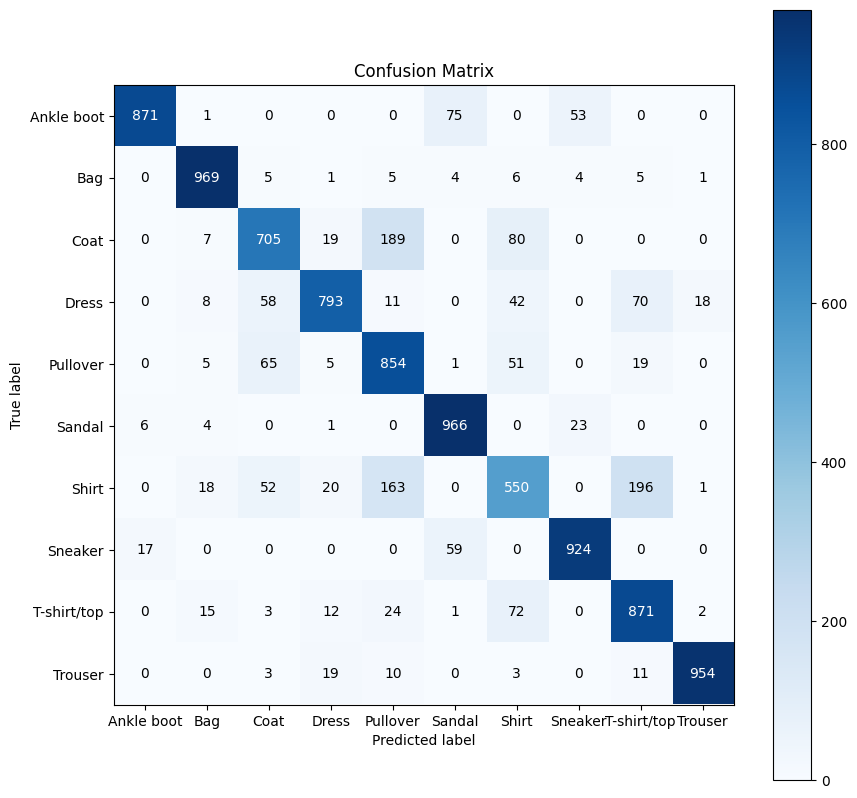

In [ ]:
test_acc,test_pred=test_model()
ytest_pred=[class_names[k] for k in test_pred]
ytest=[class_names[k]  for k in y_test]
confusion_mat=skplt.metrics.plot_confusion_matrix(ytest,ytest_pred,figsize=(10,10))

In [ ]:
sweep_id = wandb.sweep(sweep_config,project='Assignment1_ReLoaded_15thJuly')       #Uncomment for wandb

Create sweep with ID: az1ucc60
Sweep URL: https://wandb.ai/cs23z036/Assignment1_ReLoaded_15thJuly/sweeps/az1ucc60


In [ ]:
wandb.agent(sweep_id, Train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: n8pys57q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: 6kc8d0zo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: ct9tk59n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: i3bcxrsa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: b6nfniox with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: tswseg7x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: fjfgog5c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: sspeivna with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: b2aww76n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: 71kwupqm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: 1zoauc60 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: dcyqtzpv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: vczwrbwk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: py4kichm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: bu8hr5dl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: i4iudy7t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: t201yue7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: dch2j4ha with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: z6xh2mrv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: filuiqe8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: h6i993dc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: hzft6d5g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: f5v1ckns with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: 02bt6ppw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: ouiky53n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: 1q4r8hts with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: aj14gc7o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: gpo5pbk8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: ue29hoac with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: 82ye2g5k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: hb94ighr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: boih4xoh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: cyoqu1pp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: t0sw9k9d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: 8f2b6g20 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: 3ex7xsk1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: up5vcfk1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: jv6i6rmr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: uvt7xecd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: spnyb9e8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: xtfr6yi5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: 47o3tcpk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kpdywmop with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: z6iwxmcj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: owq63etd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: 4ypazuzv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: e1ija0k2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: 9w77f8og with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: q7h71rl4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: h4gvz3et with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: 95avy1en with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: arscmqux with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


<ipython-input-69-b242f8bc9c43>:7: RuntimeWarning: overflow encountered in exp
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
<ipython-input-69-b242f8bc9c43>:7: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005
no of hidden layers,3


wandb: Agent Starting Run: odua6hcd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: s916rrkb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: 4fgj0sd2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


<ipython-input-69-b242f8bc9c43>:7: RuntimeWarning: overflow encountered in exp
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
<ipython-input-69-b242f8bc9c43>:7: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005
no of hidden layers,3


wandb: Agent Starting Run: ff5xsxo9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: uzwztdzj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: tva8h4nc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: r1cerupz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: i7svn7v4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,32
learning rate,0.005


wandb: Agent Starting Run: eb9j646a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: cuhylrgg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: qddnisvr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: xavier


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Agent Starting Run: zlnd1rmm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.05
wandb: 	wt_init: random


batch size,▁
epochs,▁
layer size,▁
learning rate,▁
no of hidden layers,▁
validation accuracy,▁
validation loss,▁
batch size,32
epochs,5
layer size,64
learning rate,0.005


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
